In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [2]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

#### Table Summary Function

In [3]:
def table_summary(data_frame: pd.DataFrame, only_missing_data = True):

  data_types = []
  for col in data_frame.columns:
    data_types.append(data_frame[col].dtypes)
    
  data_frame = data_frame.isnull()

  table = pd.DataFrame(columns=['Columns','Data_type', "Missing_data", "Available_data", "Total"])
  table = table.loc[:0]
  
  record = []
  missing_value = 0
  available = 0
  
  for i, column in enumerate(data_frame.columns.values.tolist()):
    type = data_types[i]
    for row in data_frame[column]:
      if row == True:
        missing_value += 1
      else:
        available +=1
    
    record.append(column)
    record.append(type)
    record.append(missing_value)
    record.append(available)
    record.append(missing_value + available)

    table.loc[len(table)] = record
    
    # reset
    missing_value = 0
    available = 0
    record = []
    type = ""
  
  if only_missing_data:
    return table[table['Missing_data'] > 0]
  else:
    return table

#### Load dataset

In [4]:
url = 'https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DA0101EN-Coursera/medical_insurance_dataset.csv'

df = pd.read_csv(url)

df.head()

,19,1,27.9,0,1.1,3,16884.924
0,18,2,33.770,1,0,4,1725.55230
1,28,2,33.000,3,0,4,4449.46200
2,33,2,22.705,0,0,1,21984.47061
3,32,2,28.880,0,0,1,3866.85520
4,31,1,25.740,0,?,4,3756.62160


### Add headers

In [5]:
headers = ['age', 'gender', 'bmi', 'no_of_children', 'smoker', 'region', 'charges']
df.columns = headers

df.head()

,age,gender,bmi,no_of_children,smoker,region,charges
0,18,2,33.770,1,0,4,1725.55230
1,28,2,33.000,3,0,4,4449.46200
2,33,2,22.705,0,0,1,21984.47061
3,32,2,28.880,0,0,1,3866.85520
4,31,1,25.740,0,?,4,3756.62160


Now, replace the '?' entries with 'NaN' values.

In [6]:
df.replace('?', np.NAN, inplace=True)

In [7]:
table_summary(df, only_missing_data=False)


,Columns,Data_type,Missing_data,Available_data,Total
0,age,object,4,2767,2771
1,gender,int64,0,2771,2771
2,bmi,float64,0,2771,2771
3,no_of_children,int64,0,2771,2771
4,smoker,object,7,2764,2771
5,region,int64,0,2771,2771
6,charges,float64,0,2771,2771


Handle missing data:

- For continuous attributes (e.g., age), replace missing values with the mean.
- For categorical attributes (e.g., smoker), replace missing values with the most frequent value.
- Update the data types of the respective columns.
- Verify the update using `df.info()`.

In [8]:
maxValue = df['smoker'].value_counts().idxmax()
# Replace with most frequent entry
df['smoker'].replace(np.NaN, maxValue, inplace=True)

# mean age
mean_age = df['age'].astype(float).mean(axis=0)
df['age'].replace(np.NaN, mean_age, inplace=True)

# convert 'age' and 'smoker' to int
df[['age', 'smoker']] = df[['age', 'smoker']].astype(int)

In [9]:
table_summary(df, False)

,Columns,Data_type,Missing_data,Available_data,Total
0,age,int32,0,2771,2771
1,gender,int64,0,2771,2771
2,bmi,float64,0,2771,2771
3,no_of_children,int64,0,2771,2771
4,smoker,int32,0,2771,2771
5,region,int64,0,2771,2771
6,charges,float64,0,2771,2771


Also note, that the charges column has values which are more than 2 decimal places long. Update the charges column such that all values are rounded to nearest 2 decimal places. Verify conversion by printing the first 5 values of the updated dataframe.

In [10]:
# Converting the 'Charges' to 2 decimal places
# df[["charges"]] = np.round(df[["charges"]],2)
df[['charges']] = df[['charges']].round(2)

df[['charges']].head()

,charges
0,1725.55
1,4449.46
2,21984.47
3,3866.86
4,3756.62


# Task 3: Exploratory Data Analysis (EDA)

Implement the regression plot for charges with respect to bmi

(0.0, 66902.85800000001)

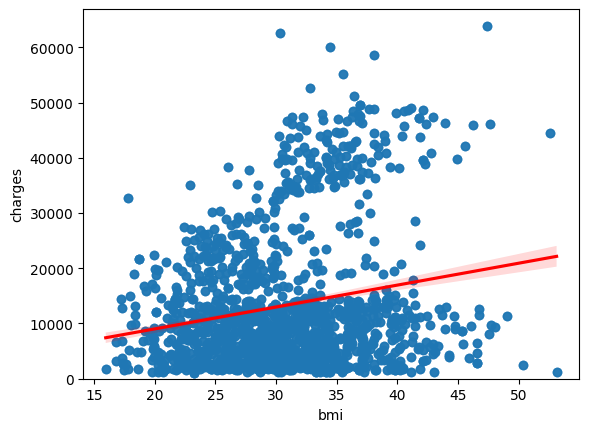

In [11]:
sns.regplot(data=df, x='bmi', y='charges', line_kws={"color": "red"})
plt.ylim(0,)

### Implement the box plot for charges with respect to smoker.

<Axes: xlabel='smoker', ylabel='charges'>

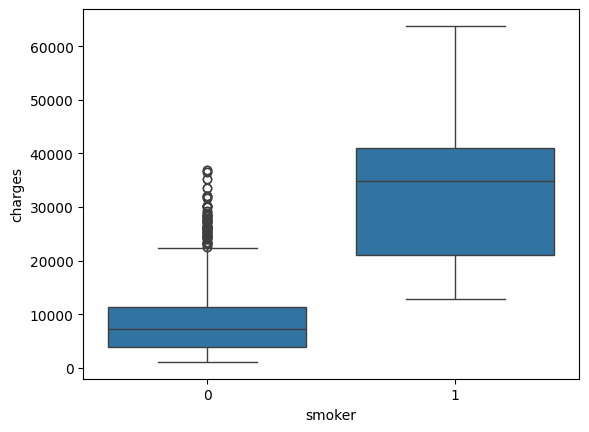

In [12]:
sns.boxplot(data=df, x='smoker', y='charges')

### Print the correlation matrix for the dataset.

In [13]:
df.corr()

,age,gender,bmi,no_of_children,smoker,region,charges
age,1.000000,-0.026584,0.112859,0.037126,-0.022290,-0.006969,0.298892
gender,-0.026584,1.000000,0.042766,0.015693,0.083125,0.022360,0.062959
bmi,0.112859,0.042766,1.000000,-0.001642,0.011824,0.271200,0.199906
no_of_children,0.037126,0.015693,-0.001642,1.000000,0.007016,-0.025594,0.066551
smoker,-0.022290,0.083125,0.011824,0.007016,1.000000,0.053839,0.789141
region,-0.006969,0.022360,0.271200,-0.025594,0.053839,1.000000,0.054018
charges,0.298892,0.062959,0.199906,0.066551,0.789141,0.054018,1.000000


# Task 4: Model Development


Fit a linear regression model that may be used to predict the `charges` value, just by using the `smoker` attribute of the dataset. Print the $ R^2 $ score of this model.

In [21]:
lR = LinearRegression()
X = df[['smoker']]
Y = df['charges']

# Fit
lR.fit(X, Y)

# R2
print(lR.score(X, Y))

0.6227430402464125


Fit a linear regression model that may be used to predict the `charges` value, just by using all other attributes of the dataset. Print the $ R^2 $ score of this model. You should see an improvement in the performance.

In [23]:
lr1 = LinearRegression()
Z = df.drop('charges', axis=1)

# Fit
lr1.fit(Z, Y)

#R2
print(lr1.score(Z, Y))

0.7505888664568174



Create a training pipeline that uses StandardScaler(), PolynomialFeatures() and LinearRegression() to create a model that can predict the charges value using all the other attributes of the dataset. There should be even further improvement in the performance.

In [25]:
# Pipelinie
input = [('scale', StandardScaler()), ('polynomial', PolynomialFeatures()), ('model', LinearRegression())]

pipe = Pipeline(input)

Z = Z.astype(float)

pipe.fit(Z, Y)
Ypipe = pipe.predict(Z)

print(r2_score(Y, Ypipe))

0.845371324311478


# Model Refinement

Split the data into training and testing subsets, assuming that 20% of the data will be reserved for testing.

In [29]:
x_train, x_test, y_train, y_test = train_test_split(Z, Y, test_size=0.2, random_state=1) 

Initialize a Ridge regressor that used hyperparameter 
. Fit the model using training data data subset. Print the 
 score for the testing data.

In [30]:
ridgeModel = Ridge(alpha=1) 

ridgeModel.fit(x_train, y_train)

yhat = ridgeModel.predict(x_test)

print(r2_score(y_test, yhat))

0.7255411011425926


Apply polynomial transformation to the training parameters with degree=2. Use this transformed feature set to fit the same regression model, as above, using the training subset. Print the 
 score for the testing subset.

In [32]:
pF = PolynomialFeatures(degree=2)

x_train_pF = pF.fit_transform(x_train)
x_test_pF = pF.fit_transform(x_test)

ridgeModel.fit(x_train_pF, y_train)
yhat = ridgeModel.predict(x_test_pF)

print(r2_score(y_test, yhat))

0.8206111870028108
